In [1]:
# 注意力评分函数
'''10.2节使⽤了⾼斯核来对查询和键之间的关系建模。(10.2.6)中的⾼斯核指数部分可以视为注意⼒评分函数
(attention scoring function),简称评分函数(scoring function),然后把这个函数的输出结果输⼊到softmax
函数中进⾏运算。通过上述步骤，将得到与键对应的值的概率分布(即注意⼒权重).最后，注意⼒汇聚的输出
就是基于这些注意⼒权重的值的加权和

从宏观来看，上述算法可以⽤来实现 图10.1.3中的注意⼒机制框架。图10.3.1说明了如何将注意⼒汇聚的输出
计算成为值的加权和，其中a表⽰注意⼒评分函数。由于注意⼒权重是概率分布，因此加权和其本质上是加
权平均值.选择不同的注意⼒评分函数a会导致不同的注意⼒汇聚操作。本节将介绍两个流⾏的评分函数，稍后将
用他们来实现更复杂的注意⼒机制
'''
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 掩蔽softmax操作
'''
正如上⾯提到的，softmax操作⽤于输出⼀个概率分布作为注意力权重。在某些情况下，并⾮所有的值都应该
被纳⼊到注意⼒汇聚中。例如，为了在 9.5节中⾼效处理⼩批量数据集，某些⽂本序列被填充了没有意义的
特殊词元。为了仅将有意义的词元作为值来获取注意⼒汇聚，可以指定⼀个有效序列⻓度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。下⾯的masked_softmax函数实现了这样的掩蔽softmax操
作（masked softmax operation），其中任何超出有效⻓度的位置都被掩蔽并置为0
'''
#@save
def masked_softmax(X, valid_lens):
    """通过在最后⼀个轴上掩蔽元素来执⾏softmax操作"""
    if valid_lens is None: # 没有有效长度
        return nn.functional.softmax(X, dim=-1) # 全部进行softmax
    # 否则:
    shape = X.shape
    valid_lens = ( # if else 简洁写法
        torch.repeat_interleave(valid_lens, shape[1]) # 重复有效长度 shape[1] 次
        if valid_lens.dim() == 1 # 若为一维,则torch.repeat_interleave(valid_lens, shape[1])
        else valid_lens.reshape(-1) # 否则重构,其中-1为模糊控制
    )
    # 最后⼀轴上被掩蔽的元素使⽤⼀个⾮常⼤的负值替换，从⽽其softmax输出为0
    X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) # mask 掩码数组
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
'''为了演⽰此函数是如何⼯作的，考虑由两个2 × 4矩阵表⽰的样本，这两个样本的有效⻓度分别为2和3。经过
掩蔽softmax操作，超出有效⻓度的值都被掩蔽为0
'''
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])) # 二维掩码

tensor([[[0.3683, 0.6317, 0.0000, 0.0000],
         [0.5283, 0.4717, 0.0000, 0.0000]],

        [[0.5002, 0.2645, 0.2353, 0.0000],
         [0.4215, 0.2782, 0.3003, 0.0000]]])

In [4]:
'同样，也可以使⽤⼆维张量，为矩阵样本中的每⼀⾏指定有效⻓度'
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3181, 0.1971, 0.4847, 0.0000]],

        [[0.6151, 0.3849, 0.0000, 0.0000],
         [0.2901, 0.2898, 0.2238, 0.1963]]])

In [5]:
# 加性注意力
''' 
⼀般来说，当查询和键是不同长度的矢量时，可以使用加性注意⼒作为评分函数。给定查询q∈Rq和键k∈Rk，
加性注意⼒（additive attention）的评分函数为

a(q, k) = w⊤^v * tanh(Wqq + Wkk) # 多层感知机 MLP

其中可学习的参数是Wq∈Rh×q、Wk∈Rh×k和 wv∈Rh.如 (10.3.3)所⽰，将查询和键连结起来后输⼊到⼀
个多层感知机（MLP）中，感知机包含⼀个隐藏层，其隐藏单元数是⼀个超参数h。通过使⽤tanh作为激活函
数，并且禁⽤偏置项
'''
#@save
class AdditiveAttention(nn.Module): # 加性注意力
    """加性注意⼒"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使⽤⼴播⽅式进⾏求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有⼀个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens) # 注意力权重
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values) # 随机失活 计算加权平均值

In [6]:
''' ⽤⼀个⼩例⼦来演⽰上⾯的AdditiveAttention类，其中查询、键和值的形状为(批量大小，步数或词元序列
长度，特征⼤⼩)，实际输出为(2, 1, 20)、(2, 10, 2)和(2, 10, 4)。注意⼒汇聚输出的形状为(批量⼤⼩，
查询的步数，值的维度)
'''
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的⼩批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

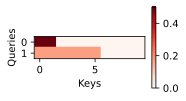

In [7]:
'''尽管加性注意⼒包含了可学习的参数，但由于本例⼦中每个键都是相同的，所以注意⼒权重是均匀的，由指
定的有效⻓度决定
'''
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [9]:
# 缩放点积注意力
''' 
使⽤点积可以得到计算效率更⾼的评分函数，但是点积操作要求查询和键具有相同的⻓度d。假设查询和键
的所有元素都是独⽴的随机变量，并且都满⾜零均值和单位⽅差，那么两个向量的点积的均值为0，⽅差为d。
为确保⽆论向量⻓度如何，点积的⽅差在不考虑向量⻓度的情况下仍然是1，我们再将点积除以
√d，则缩放点积注意⼒（scaled dot-product attention）评分函数为：
a(q, k) = q⊤k/√d
在实践中，我们通常从⼩批量的⻆度来考虑提⾼效率，例如基于n个查询和m个键－值对计算注意⼒
下⾯的缩放点积注意⼒的实现使⽤了暂退法进⾏模型正则化
'''
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意⼒"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values) # 使用暂退法进⾏模型正则化

In [10]:
'''为了演⽰上述的DotProductAttention类，我们使⽤与先前加性注意⼒例⼦中相同的键、值和有效⻓度。对于
点积操作，我们令查询的特征维度与键的特征维度大小相同'''
queries = torch.normal(0, 1, (2, 1, 2)) # 令查询的特征维度与键的特征维度大小相同
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

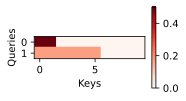

In [12]:
'''与加性注意⼒演⽰相同，由于键包含的是相同的元素，⽽这些元素⽆法通过任何查询进⾏区分，因此获得了
均匀的注意⼒权重'''
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [ ]:
'''⼩结
• 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意⼒评分函数会带来不同的注意⼒汇
聚操作。
• 当查询和键是不同长度的矢量时，可以使用可加性注意⼒评分函数。当它们的长度相同时，使⽤缩放的
"点－积"注意⼒评分函数的计算效率更⾼
'''